#Testing some of Elhers indicators

## Instantaneous Trend

In [146]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [147]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [148]:
# Load data, specifically AAPL minute OHLC data from 2015-07-14
data = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
aapl = data.CLOSE.as_matrix()     #(0.5 * (data.HIGH + data.LOW)).as_matrix()

In [149]:
# Define an SMA lag and the equivalent EMA alpha.
SMA_lag = 15
alpha = 2.0 / (SMA_lag + 1)       #0.07

a_ = (alpha / 2.0) ** 2
b_ = (1 - alpha)

IT = np.zeros(len(aapl))
LT = np.zeros(len(aapl))     # Instantaneous Trend Lead Trigger

# Make the first indicator values equal to prices for faster convergence.
IT[:2] = aapl[:2]
LT[:2] = aapl[:2]

for n in range(2, len(aapl)):
    IT[n] = (alpha - a_) * aapl[n] + (2 * a_) * aapl[n-1] - (alpha - 3 * a_) * aapl[n-2] \
            + (2 * b_) * IT[n-1] - (b_ ** 2) * IT[n-2]
    LT[n] = 2 * IT[n] - IT[n-2]

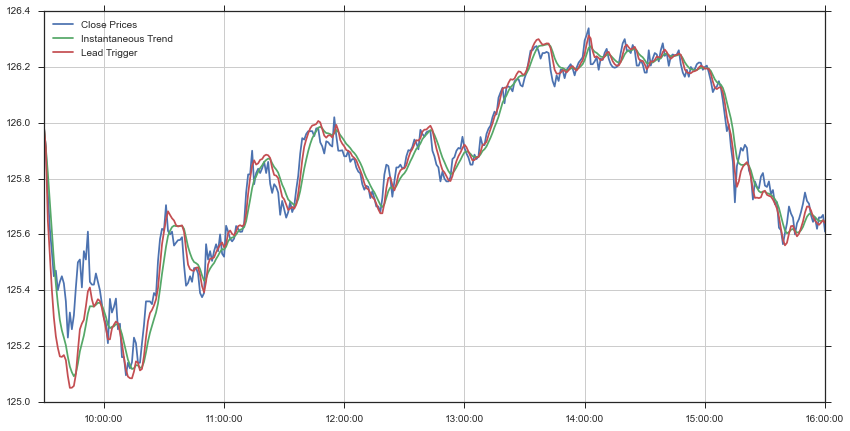

In [150]:
plt.plot(df.index, data.CLOSE.as_matrix(), label='Close Prices')
plt.plot(df.index, IT, label='Instantaneous Trend')
plt.plot(df.index, LT, label='Lead Trigger')
plt.legend(loc='upper left')
plt.grid()

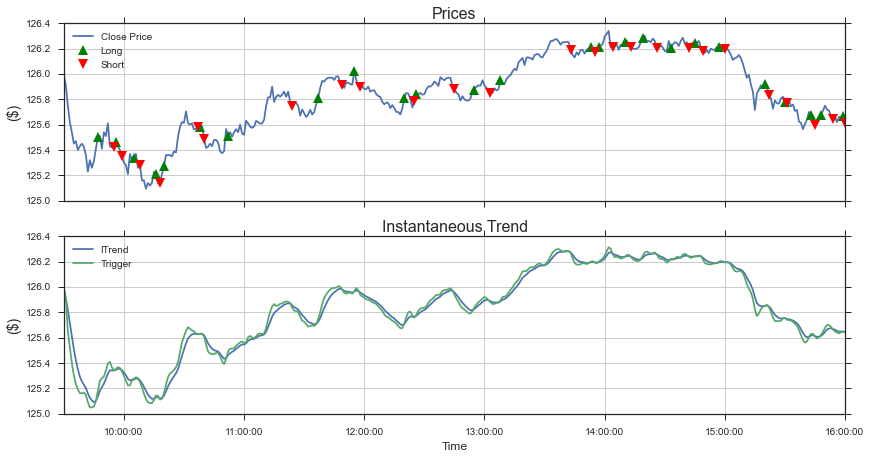

In [151]:
df = pd.DataFrame(np.transpose(np.vstack((data.CLOSE, IT, LT))), index=data.index,
                  columns=['Price', 'Trend', 'Trigger'])

# Generate a boolean array to use as index for the events.
long_signal = (df.Trend.shift() > df.Trigger.shift()) & (df.Trend < df.Trigger)
short_signal = (df.Trend.shift() < df.Trigger.shift()) & (df.Trend > df.Trigger)

# This plot will contains two subplos sharing the x axis.
fig, ax = plt.subplots(2, sharex=True)
time = df.index

# The first subplot is the close price and the orders.
ax[0].set_title('Prices', fontsize=16)
ax[0].plot(time, df.Price, label='Close Price')
ax[0].plot(time[long_signal], df.Price[long_signal], linestyle='None', marker='^', 
           color='g', markersize=10, label='Long')
ax[0].plot(time[short_signal], df.Price[short_signal], linestyle='None', marker='v',
           color='r', markersize=10, label='Short')
ax[0].set_ylabel('($)', fontsize=14)
ax[0].legend(loc='upper left')
ax[0].grid()

# The second subplot are the indicator and the trigger.
ax[1].set_title('Instantaneous Trend', fontsize=16)
ax[1].plot(time, df.Trend, label='ITrend')
ax[1].plot(time, df.Trigger, label='Trigger')
ax[1].set_ylabel('($)', fontsize=14)
ax[1].set_xlabel('Time', fontsize=12)
ax[1].legend(loc='upper left')
ax[1].grid()

Seems the Instantaneous Trend - Lead Trigger schema only works fine in strong trend situation. If not, there are many false signals.

# SuperSmoother